In [2]:
import spacy
#nlp = spacy.load("it_core_news_sm")

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


In [ ]:
###################### carica dataset LDO 20-21 ############################ 

dataLDO2020 = pd.read_excel('/home/a.renda/to_move/LDO/filtrato_per_keyword/20-21_LDO_26K/LDO_20200101_20210101 pulito.ods', engine='odf')
dataLDO2021=pd.read_excel('/home/a.renda/to_move/LDO/filtrato_per_keyword/20-21_LDO_26K/LDO_20210101_20220101 pulito.ods', engine='odf')

In [ ]:
# Filtra le righe che non contengono numeri (escludendo anche i NaN)
dataLDO2021 = dataLDO2021[dataLDO2021['nosologico'].astype(str).str.contains(r'\d')]
#rimosse 212 righe

In [4]:
print("\nColumns LDO 20-21:", dataLDO2020.columns)
print("\nColumns LDO 21-22:", dataLDO2021.columns)
print("\nShape LDO 20-21:", dataLDO2020.shape)
print("\nShape LDO 21-22:", dataLDO2021.shape)


Columns LDO 20-21: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Columns LDO 21-22: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Shape LDO 20-21: (24123, 17)

Shape LDO 21-22: (39274, 17)


In [ ]:
###################### carica database filtrato ################

databaseFiltrato=pd.read_csv('/home/a.renda/to_move/LDO/labeled/20-21_341/DatabaseFiltrato.csv', sep=';')
print(databaseFiltrato.shape)
print(databaseFiltrato.columns) # la prima colonna è solo un contatore

(26237, 3)
Index(['Unnamed: 0', 'nosologico', 'label'], dtype='object')


In [ ]:
# Filtra le righe che non contengono numeri (escludendo anche i NaN)
databaseFiltrato = databaseFiltrato[databaseFiltrato['nosologico'].astype(str).str.contains(r'\d')]

#tolte 5 righe

In [ ]:
############################ filtra ldo 2020 ######################

# Converti la colonna 'nosologico' del secondo dataset in int
databaseFiltrato['nosologico'] = pd.to_numeric(databaseFiltrato['nosologico'], errors='coerce')

# Trova i nosologici comuni
comuni2020 = dataLDO2020['nosologico'].isin(databaseFiltrato['nosologico'])

# Filtra il primo dataset
dataset_filtrato2020 = dataLDO2020[comuni2020]
print(dataset_filtrato2020.columns)
print(dataset_filtrato2020.shape)


Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')
(8974, 17)


In [ ]:
############################ filtra ldo 2021 ######################

# Trova i nosologici comuni
comuni2021 = dataLDO2021['nosologico'].isin(databaseFiltrato['nosologico'])

# Filtra il primo dataset
dataset_filtrato2021 = dataLDO2021[comuni2021]
print(dataset_filtrato2021.columns)
print(dataset_filtrato2021.shape)

Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')
(17218, 17)


In [ ]:
######################## merge ldo2020 e ldo 2021 filtrati ###################################

merged_dataset = pd.concat([dataset_filtrato2020, dataset_filtrato2021], ignore_index=True) # non ci sono duplicati tra i due dataset 

# Risultato finale
print("\nColumns merged dataset:",merged_dataset.columns)
print("\nShape merged dataset:",merged_dataset.shape)
print(merged_dataset['testo'][0])



Columns merged dataset: Index(['nosologico', 'time_inserimento', 'dataInizio', 'dataFine', 'testo',
       'motivo_ricovero', 'anamnesi', 'esameobiettivo', 'terapiafarmaingresso',
       'decorso', 'laboratorio', 'interventi', 'followup', 'terapie2',
       'terapie3', 'esami', 'reparto'],
      dtype='object')

Shape merged dataset: (26192, 17)
ObesitÃ  di classe III complicata da ipertensione arteriosa, insulino-resistenza con ridotta tolleranza glucidica, epatomegalia steatosica, insufficienza venosa arti inferiori, ipovitaminosi D e ernia iatale,colelitiasi trattata con colecistectomia,regredita a obesitÃ  di classe I dopo intervento chirurgico di bypass gastrico (2011) al peso di 142 Kg con persistenza di ipovitaminosi D, remissione delle comorbiditÃ  e comparsa di ipoglicemia reattiva sintomatica. Micronodulia tiroidea. Anemia microcitica ipocrocromica, sideropenica. Emorroidi congeste del canale anale.Terapia consigliata alla dimissione:Pr: Bariatrifast cpS: 1 cp ore 8.00Pr: Gl

In [ ]:
######################## carica dataset con nosologici positivi #####################

Positivi= pd.read_excel('/home/a.renda/to_move/LDO/labeled/20-21_341/NosologiciPositivi_341.xlsx')

In [ ]:
################################### aggiungere la colonna positivi #########################################

# Convertire la colonna 'Nosologico' in numerico nel dataset NosologiciPositivi
nosologici_positivi = pd.to_numeric(Positivi['NosologiciPositivi'], errors='coerce').dropna()

# Creare la colonna 'positivi' nel DataFrame merged_dataset
merged_dataset['positivi'] = merged_dataset['nosologico'].isin(nosologici_positivi).astype(int)


# Contare quanti 1 e quanti 0 ci sono nella colonna 'positivi'
count_positivi = merged_dataset['positivi'].value_counts()

# Stampa i risultati
print("\nConteggio dei valori nella colonna 'positivi':")
print(f"Numero di 1 (positivi): {count_positivi.get(1, 0)}")
print(f"Numero di 0 (non positivi): {count_positivi.get(0, 0)}")


Conteggio dei valori nella colonna 'positivi':
Numero di 1 (positivi): 341
Numero di 0 (non positivi): 25851


In [ ]:
# Unire parole e numeri in 'reparto' rimuovendo lo spazio e sostituendo con un trattino
merged_dataset['reparto'] = merged_dataset['reparto'].str.replace(r'(\w) (\d)', r'\1-\2', regex=True)

# Visualizza i risultati
print(merged_dataset['reparto'].head())


0    UO Endocrinologia-1
1    UO Endocrinologia-1
2    UO Endocrinologia-1
3    UO Endocrinologia-1
4    UO Endocrinologia-1
Name: reparto, dtype: object


In [ ]:
###################### pulisci il testo: risoluzione di errori di codifica, sostituzione caratteri speciali #######################
import ftfy

# Applica ftfy.fix_text() a tutte le colonne di testo nel dataset, gestendo i valori non testuali
for col in merged_dataset.select_dtypes(include='object').columns:
    merged_dataset[col] = merged_dataset[col].apply(lambda x: ftfy.fix_text(x) if isinstance(x, str) else x)


In [ ]:
############### Crea testo combinato con tutte le colonne di testo #####################################

# Seleziona le colonne di testo specificate
colonne_testo = ['testo', 'motivo_ricovero', 'anamnesi', 'esameobiettivo',
                  'terapiafarmaingresso', 'decorso', 'laboratorio', 'interventi',
                  'followup', 'terapie2', 'terapie3', 'esami', 'reparto']

# Crea un testo combinato ignorando i NaN
merged_dataset['testo_combinato'] = merged_dataset[colonne_testo].apply(
    lambda row: ' '.join(
        [str(row[col]) for col in colonne_testo if not pd.isna(row[col])]
    ),
    axis=1
)

# Stampa le prime righe per vedere il risultato
print(merged_dataset['testo_combinato'].head())
print(merged_dataset['testo_combinato'][0]) 


0    Obesità di classe III complicata da ipertensio...
1    Carcinoma della tiroide a cellule ossifile (4 ...
2    Carcinoma papillare differenziato della tiroid...
3    gozzo multinodulare con quattro focolai di car...
4    Carcinoma papillare (1,5 cm) variante classica...
Name: testo_combinato, dtype: object
Obesità di classe III complicata da ipertensione arteriosa, insulino-resistenza con ridotta tolleranza glucidica, epatomegalia steatosica, insufficienza venosa arti inferiori, ipovitaminosi D e ernia iatale,colelitiasi trattata con colecistectomia,regredita a obesità di classe I dopo intervento chirurgico di bypass gastrico (2011) al peso di 142 Kg con persistenza di ipovitaminosi D, remissione delle comorbidità e comparsa di ipoglicemia reattiva sintomatica. Micronodulia tiroidea. Anemia microcitica ipocrocromica, sideropenica. Emorroidi congeste del canale anale.Terapia consigliata alla dimissione:Pr: Bariatrifast cpS: 1 cp ore 8.00Pr: Glucobay 50 mg cpS: 1 cp a colazione 1 cp 

In [14]:
####################### MEDIA NUMERO DI PAROLE NELLE COLONNE ###########################

# Funzione per calcolare il numero di parole
def count_words(text):
    if isinstance(text, str):  # Verifica se il testo è una stringa
        return len(text.split())  # Conta le parole
    elif isinstance(text, (int, float)):  # Se è un numero
        return 1  # Considera il numero come una parola
    return 0  # Restituisce 0 se non è una stringa o un numero


# Calcola la lunghezza media in parole per ciascuna colonna di testo
for colonna in colonne_testo:
    word_counts = merged_dataset[colonna].apply(count_words)  # Conta le parole in ogni stringa
    average_word_count = word_counts.mean()  # Calcola la lunghezza media
    print(f"Lunghezza media della colonna '{colonna}' in parole: {average_word_count:.2f}")

# Calcola la lunghezza media in parole della colonna di testo combinato
word_counts_combined = merged_dataset['testo_combinato'].apply(count_words)  # Conta le parole in ogni stringa
average_word_count_combined = word_counts_combined.mean()  # Calcola la lunghezza media
print(f"Lunghezza media della colonna 'testo_combinato' in parole: {average_word_count_combined:.2f}")

Lunghezza media della colonna 'testo' in parole: 26.62
Lunghezza media della colonna 'motivo_ricovero' in parole: 13.00


Lunghezza media della colonna 'anamnesi' in parole: 277.10
Lunghezza media della colonna 'esameobiettivo' in parole: 47.00
Lunghezza media della colonna 'terapiafarmaingresso' in parole: 18.18
Lunghezza media della colonna 'decorso' in parole: 233.98
Lunghezza media della colonna 'laboratorio' in parole: 182.96
Lunghezza media della colonna 'interventi' in parole: 65.72
Lunghezza media della colonna 'followup' in parole: 125.41
Lunghezza media della colonna 'terapie2' in parole: 3.55
Lunghezza media della colonna 'terapie3' in parole: 49.64
Lunghezza media della colonna 'esami' in parole: 21.96
Lunghezza media della colonna 'reparto' in parole: 3.58
Lunghezza media della colonna 'testo_combinato' in parole: 1064.90


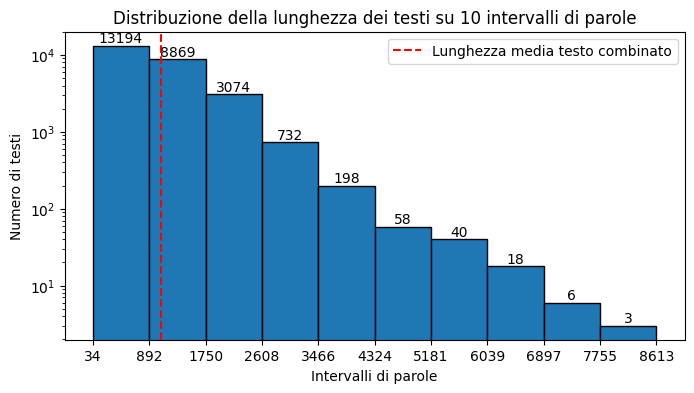

Lunghezza massima testo_combinato (in parole): 8613
Lunghezza minima testo_combinato (in parole): 34


In [15]:
############################# ISTOGRAMMA LUNGHEZZA TESTO COMBINATO  ############################

import matplotlib.pyplot as plt

# Calcola la lunghezza del testo combinato
word_counts_combined = merged_dataset['testo_combinato'].apply(count_words)

# Calcola i valori minimi e massimi
lunghezza_min = word_counts_combined.min()
lunghezza_max = word_counts_combined.max()

# Definisce il numero di bin
num_bin = 10

# Calcola la larghezza delle bin
bin_width = (lunghezza_max - lunghezza_min) / num_bin

# Crea una lista di bin
bins = [lunghezza_min + i * bin_width for i in range(num_bin + 1)]

# Crea la figura più larga
plt.figure(figsize=(8, 4))

# Calcola l'istogramma e i valori delle altezze (n) e dei bin
n, bins, patches = plt.hist(
    word_counts_combined,  # Usa i conteggi delle parole già calcolati
    bins=bins,
    edgecolor='black'
)

# Applica la scala logaritmica sull'asse y
plt.yscale('log')

# Calcola e aggiungi la linea della lunghezza media del testo combinato
average_word_count_combined = word_counts_combined.mean()  # Questo ora è un valore scalare
plt.axvline(x=average_word_count_combined, color='red', linestyle='--', label='Lunghezza media testo combinato')

# Aggiunge il titolo e le etichette degli assi
plt.title('Distribuzione della lunghezza dei testi su 10 intervalli di parole')
plt.xlabel('Intervalli di parole')
plt.ylabel('Numero di testi')

# Mostra le etichette delle bin
plt.xticks(bins)

# Aggiunge una label con il valore sopra ogni barra
for i in range(len(n)):
    plt.text(bins[i] + bin_width / 2, n[i], str(int(n[i])), ha='center', va='bottom')

# Mostra la legenda
plt.legend()

# Mostra il grafico
plt.show()

# Stampa i valori minimi e massimi del testo combinato
print(f"Lunghezza massima testo_combinato (in parole): {lunghezza_max}")
print(f"Lunghezza minima testo_combinato (in parole): {lunghezza_min}")


In [16]:
################# DIMENSIONE VOCABOLARIO ###########################

# Calcola il vocabolario dalla colonna 'testo_combinato_preprocessed'
vocab_set = set()
for testo in merged_dataset['testo_combinato']:
    if isinstance(testo, str):  # Assicurati che il testo non sia NaN
        vocab_set.update(testo.split())

# Calcola la dimensione del vocabolario
vocabolario_dimensione = len(vocab_set)
print(f"Dimensione del vocabolario: {vocabolario_dimensione}")

Dimensione del vocabolario: 1089237


In [ ]:
####################### PRE PROCESSING con parole composte ###########################

import spacy
import pandas as pd
import re

# Carica il modello SpaCy per l'italiano
nlp = spacy.load("it_core_news_lg", disable=["parser", "ner"])

# Funzione per pulire i token (inclusi numeri, punti e virgole)
def clean_token(token):
    
    # Mantieni numeri, lettere, rimuovendo altri caratteri speciali
    #cleaned_token = re.sub(r'[^a-zA-Z0-9àèéìòùÀÈÉÌÒÙ]', '', token)

    # Sostituisce tutti i caratteri non alfanumerici (inclusi simboli, punteggiatura, ecc.) con uno spazio.
    #cleaned_token = re.sub(r'[^a-zA-Z0-9àèéìòùÀÈÉÌÒÙ]', ' ', token) 
    #cleaned_token = re.sub(r'[^a-zA-Z0-9àèéìòùÀÈÉÌÒÙ,]', ' ', token) # questo per conservare i numeri con la virgola
    
    # Sostituisce tutti i caratteri non alfanumerici (inclusi simboli, punteggiatura, numeri, ecc.) con uno spazio.
    cleaned_token = re.sub(r'[^a-zA-ZàèéìòùÀÈÉÌÒÙ]', ' ', token)
    #cleaned_token = re.sub(r'\s+', ' ', cleaned_token).strip()  # Normalizza gli spazi multipli
    
    return cleaned_token

# Funzione per tokenizzare e preprocessare il testo
def preprocess_text(row):
    if not isinstance(row, str):  # Verifica che il dato sia una stringa valida
        return ""  # Restituisce una stringa vuota se non valido
    
    # Rimuove date nel formato 'dd/mm/yyyy' e 'dd/mm/yy'
    row = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '', row)
    row = re.sub(r'\d{1,2}/\d{1,2}', '', row)  # Rimuove numeri separati da /
    
    # Gestisci i punti tra le parole (ad esempio "v.allegato" diventa "v allegato")
    #row = re.sub(r'(\w)\.(\w)', r'\1 \2', row)  # Aggiunge uno spazio tra parole separate da punto

    # Gestisci numeri decimali con virgola (esempio "1,2" non deve diventare "12")
    #row = re.sub(r'(\d),(\d)', r'\1,\2', row)  # Mantieni la virgola nei numeri decimali
    
    # Aggiunge spazi tra numeri e lettere (es. "800duloxetina" -> "800 duloxetina")
    row = re.sub(r'(\d+)([a-zA-Z]+)', r'\1 \2', row)
    row = re.sub(r'([a-zA-Z]+)(\d+)', r'\1 \2', row)

    # Tokenizza il testo con SpaCy
    doc = nlp(row)
    
    # Filtra stopwords, punteggiatura e token senza embedding
    tokens_puliti = [
        clean_token(token.lemma_.lower())  # Lemmatizza e pulisce il token
        for token in doc
        if not token.is_punct and not token.is_stop #and token.has_vector  #(Solo token con vettori validi)
    ]
    
    # Rimuove eventuali stringhe vuote dai token puliti
    tokens_puliti = [token for token in tokens_puliti if token]
    
    # Ricombina i token in una stringa
    return " ".join(tokens_puliti)

# Applica il preprocessing alla colonna del dataset
merged_dataset['testo_combinato_preprocessed'] = merged_dataset['testo_combinato'].apply(preprocess_text)

# Visualizza i risultati per le prime righe
print(merged_dataset[['testo_combinato', 'testo_combinato_preprocessed']].head(10))

# Controlla se ci sono valori vuoti nel preprocessing
print("Numero di righe preprocessate vuote:", merged_dataset['testo_combinato_preprocessed'].str.strip().eq("").sum())


                                     testo_combinato  \
0  Obesità di classe III complicata da ipertensio...   
1  Carcinoma della tiroide a cellule ossifile (4 ...   
2  Carcinoma papillare differenziato della tiroid...   
3  gozzo multinodulare con quattro focolai di car...   
4  Carcinoma papillare (1,5 cm) variante classica...   
5  Carcinoma papillare della tiroide (7 mm) multi...   
6  Carcinoma scarsamente differenziato (9,5 cm) i...   
7  Obesità di III complicata da epatomegalia stea...   
8  Malattia di Cushing da microadenoma ACTH secer...   
9  Gozzo multinodulare non tossico con nodulo dom...   

                        testo_combinato_preprocessed  
0  obesità classe iii complicare ipertensione art...  
1  carcinoma tiroide cellula ossifile   cm ampiam...  
2  carcinoma papillare differenziare tiroide     ...  
3  gozzo multinodulare focolaio carcinoma tiroide...  
4  carcinoma papillare     cm variante classico a...  
5  carcinoma papillare tiroide   mm multifocale b... 

In [ ]:
####################### PRE PROCESSING SEPARANDO PAROLE COMPOSTE ###########################

import spacy
import pandas as pd
import re

# Carica il modello SpaCy per l'italiano
nlp = spacy.load("it_core_news_lg", disable=["parser", "ner"])

# Funzione per pulire i token (inclusi numeri, punti e virgole)
def clean_token(token):
    
    # Sostituisce tutti i caratteri non alfanumerici (inclusi simboli, punteggiatura, numeri, ecc.) con uno spazio.
    cleaned_token = re.sub(r'[^a-zA-ZàèéìòùÀÈÉÌÒÙ]', ' ', token)
    cleaned_token = re.sub(r'\s+', ' ', cleaned_token).strip()  # Normalizza gli spazi multipli
    
    return cleaned_token

# Funzione per tokenizzare e preprocessare il testo
def preprocess_text(row):
    if not isinstance(row, str):  # Verifica che il dato sia una stringa valida
        return ""  # Restituisce una stringa vuota se non valido
    
    # Rimuove date nel formato 'dd/mm/yyyy' e 'dd/mm/yy'
    row = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', '', row)
    row = re.sub(r'\d{1,2}/\d{1,2}', '', row)  # Rimuove numeri separati da /
       
    # Aggiunge spazi tra numeri e lettere (es. "800duloxetina" -> "800 duloxetina")
    row = re.sub(r'(\d+)([a-zA-Z]+)', r'\1 \2', row)
    row = re.sub(r'([a-zA-Z]+)(\d+)', r'\1 \2', row)

    # Aggiunge spazi tra parole composte tipo "vediAllegato" -> "vedi Allegato"
    row = re.sub(r'([a-zàèéìòù])([A-ZÀÈÉÌÒÙ])', r'\1 \2', row)

    # normalizza  spazi (se ci sono più spazi consecutivi, vengono ridotti a uno solo) e rimuove  spazi all'inizio e alla fine della stringa
    row = re.sub(r'[^\w\s]', ' ', row)  # Rimuove caratteri non alfanumerici e parentesi

    # Tokenizza il testo con SpaCy
    doc = nlp(row)
    
    # Filtra stopwords, punteggiatura e token senza embedding
    tokens_puliti = [
        clean_token(token.lemma_.lower())  # lemmatizzazione e pulisce il token
        for token in doc
        if not token.is_punct and not token.is_stop and len(token.text) > 1 #and token.text.isalpha() #per rimuovere token formati da una singola lettera
    ]
    
    # Applica un filtro finale per rimuovere manualmente le lettere singole
    tokens_puliti = [token for token in tokens_puliti if len(token) > 1]  # Assicura che tutte le parole siano > 1 carattere
    
    # Ricombina i token in una stringa
    return " ".join(tokens_puliti)

# Applica il preprocessing alla colonna del dataset
merged_dataset['testo_combinato_preprocessed'] = merged_dataset['testo_combinato'].apply(preprocess_text)

# Visualizza i risultati per le prime righe
print(merged_dataset[['testo_combinato', 'testo_combinato_preprocessed']].head(10))


                                     testo_combinato  \
0  Obesità di classe III complicata da ipertensio...   
1  Carcinoma della tiroide a cellule ossifile (4 ...   
2  Carcinoma papillare differenziato della tiroid...   
3  gozzo multinodulare con quattro focolai di car...   
4  Carcinoma papillare (1,5 cm) variante classica...   
5  Carcinoma papillare della tiroide (7 mm) multi...   
6  Carcinoma scarsamente differenziato (9,5 cm) i...   
7  Obesità di III complicata da epatomegalia stea...   
8  Malattia di Cushing da microadenoma ACTH secer...   
9  Gozzo multinodulare non tossico con nodulo dom...   

                        testo_combinato_preprocessed  
0  obesità classe iii complicare ipertensione art...  
1  carcinoma tiroide cellula ossifile cm ampiamen...  
2  carcinoma papillare differenziare tiroide cm l...  
3  gozzo multinodulare focolaio carcinoma tiroide...  
4  carcinoma papillare cm variante classico aspet...  
5  carcinoma papillare tiroide mm multifocale bil... 

In [16]:
############################### MEDIA NUMERO DI PAROLE TESTO PRE PROCESSATO ###########################

# Funzione per calcolare il numero di parole
def count_words(text):
    if isinstance(text, str):  # Verifica se il testo è una stringa
        return len(text.split())  # Conta le parole
    elif isinstance(text, (int, float)):  # Se è un numero
        return 1  # Considera il numero come una parola
    return 0  # Restituisce 0 se non è una stringa o un numero

# Calcola la lunghezza media in parole della colonna di testo combinato
word_counts_combined = merged_dataset['testo_combinato_preprocessed'].apply(count_words)  # Conta le parole in ogni stringa
average_word_count_combined = word_counts_combined.mean()  # Calcola la lunghezza media
print(f"Lunghezza media della colonna 'testo_combinato' preprocessato in parole: {average_word_count_combined:.2f}")

Lunghezza media della colonna 'testo_combinato' preprocessato in parole: 683.29


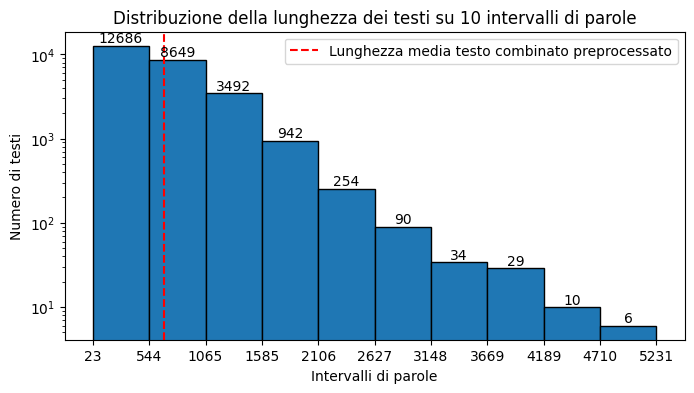

Lunghezza massima testo_combinato preprocessato (in parole): 5231
Lunghezza minima testo_combinato preprocessato (in parole): 23


In [17]:
############################ ISTOGRAMMA LUNGHEZZA TESTO COMBINATO PRE-PROCESSATO #############################

import matplotlib.pyplot as plt

# Calcola la lunghezza del testo combinato
word_counts_combined = merged_dataset['testo_combinato_preprocessed'].apply(count_words)

# Calcola i valori minimi e massimi
lunghezza_min = word_counts_combined.min()
lunghezza_max = word_counts_combined.max()

# Definisce il numero di bin
num_bin = 10

# Calcola la larghezza delle bin
bin_width = (lunghezza_max - lunghezza_min) / num_bin

# Crea una lista di bin
bins = [lunghezza_min + i * bin_width for i in range(num_bin + 1)]

# Crea la figura più larga
plt.figure(figsize=(8, 4))

# Calcola l'istogramma e i valori delle altezze (n) e dei bin
n, bins, patches = plt.hist(
    word_counts_combined,  # Usa i conteggi delle parole già calcolati
    bins=bins,
    edgecolor='black'
)

# Applica la scala logaritmica sull'asse y
plt.yscale('log')

# Calcola e aggiungi la linea della lunghezza media del testo combinato
average_word_count_combined = word_counts_combined.mean()  # Questo ora è un valore scalare
plt.axvline(x=average_word_count_combined, color='red', linestyle='--', label='Lunghezza media testo combinato preprocessato')

# Aggiunge il titolo e le etichette degli assi
plt.title('Distribuzione della lunghezza dei testi su 10 intervalli di parole')
plt.xlabel('Intervalli di parole')
plt.ylabel('Numero di testi')

# Mostra le etichette delle bin
plt.xticks(bins)

# Aggiunge una label con il valore sopra ogni barra
for i in range(len(n)):
    plt.text(bins[i] + bin_width / 2, n[i], str(int(n[i])), ha='center', va='bottom')

# Mostra la legenda
plt.legend()

# Mostra il grafico
plt.show()

# Stampa i valori minimi e massimi del testo combinato
print(f"Lunghezza massima testo_combinato preprocessato (in parole): {lunghezza_max}")
print(f"Lunghezza minima testo_combinato preprocessato (in parole): {lunghezza_min}")


In [18]:
print(merged_dataset['testo_combinato'][2])
print(merged_dataset['testo_combinato_preprocessed'][2])

Carcinoma papillare differenziato della tiroide (>4cm, lobo sinistro), variante classica, multifocale, bilaterale, limitato alla ghiandola (T3amN1Mx) associato a tiroidite linfocitaria trattato con  tiroidectomia totale  ed asportazione parziale dei linfonodi del comparto centrale (Pisa, San Rossore. Prof Galleri) e terapia radiometabolica con 131-I a scopo adiuvante (Pisa) Terapia radiometabolica con 131-I a scopo adiuvante Carcinoma papillare differenziato della tiroide (>4cm, lobo sinistro), variante classica, multifocale, bilaterale, limitato alla ghiandola (T3amN1Mx) associato a tiroidite linfocitaria trattato con  tiroidectomia totale  ed asportazione parziale dei linfonodi del comparto centrale (Pisa, San Rossore. Prof Galleri) Terapia radiometabolica con 131-I a scopo adiuvante Abbiamo programmato una visita endocrinologica (1° controllo post-ablazione, Ospedale Cisanello, Edificio 8) in regime Ambulatoriale in data 09/07/2020. Occorreranno le impegnative per 1) prelievo ematic

In [19]:
####################### DIMENSIONE VOCABOLARIO PRE-PROCESSATO ######################

from sklearn.feature_extraction.text import TfidfVectorizer

# Calcola il vocabolario dalla colonna 'testo_combinato_preprocessed'
vocab_set = set()
for testo in merged_dataset['testo_combinato_preprocessed']:
    if isinstance(testo, str):  # Assicurati che il testo non sia NaN
        vocab_set.update(testo.split())

# Calcola la dimensione del vocabolario
vocabolario_dimensione = len(vocab_set)

# Confronto tra dimensione del vocabolario e numero di features
print("Dimensione del vocabolario:", vocabolario_dimensione)


Dimensione del vocabolario: 129726


In [23]:
#######################################################################################

In [ ]:
########################## CLASSIFIERS #################

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Vettorizzazione
#vectorizer = TfidfVectorizer(max_features=5000)
#vectorizer = TfidfVectorizer()

# Definisci una lista di classificatori che vuoi provare
classifiers = {
    #'RandomForest': RandomForestClassifier(n_jobs=-1, max_depth=10, max_features=0.1, random_state=42),
    #'LogisticRegression': LogisticRegression(random_state=42, max_iter=2000),
    #'SVM': SVC(probability=True,random_state=42),
    #'KNeighbors': KNeighborsClassifier(),
    #'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42),
    #'extremeGradientBoosting': XGBClassifier( learning_rate=0.1, random_state=42, n_jobs=-1, max_depth=6),
    #'DecisionTree': DecisionTreeClassifier(max_depth=20, random_state=42),
    #'GradientBoosting': GradientBoostingClassifier(learning_rate=0.1, min_samples_split=10, random_state=42),
    #'LSTM': LSTMWrapper(embedding_layer=embedding_layer, hidden_dim=128, output_dim=1)  
}

In [ ]:
########################################################

In [26]:
import torch
print(torch.__version__)           # Per verificare la versione di PyTorch
print(torch.version.cuda)          # Per confermare la versione di CUDA usata da PyTorch
print(torch.cuda.is_available())   # Dovrebbe restituire True se PyTorch riconosce correttamente la GPU


1.13.0+cu116
11.6
True


In [30]:
!pip install spacy[cuda113]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.9 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
!python -m spacy info



============================== Info about spaCy ==============================

spaCy version    3.2.0                         
Location         /home/v.acampora/venv2/lib/python3.8/site-packages/spacy
Platform         Linux-5.4.0-187-generic-x86_64-with-glibc2.29
Python version   3.8.10                        
Pipelines        it_core_news_sm (3.2.0), it_core_news_md (3.2.0)



In [58]:
import spacy

# Assicurati che spaCy utilizzi la GPU
spacy.require_gpu()

print("spaCy sta utilizzando la GPU!")


spaCy sta utilizzando la GPU!


In [ ]:
##############################################################

In [21]:
######################## CROSS VALIDATION ########################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import numpy as np
import pandas as pd

def eval_cross_validation(pipeline, X, y, skf):
    list_reports = []
    list_auc = []  # Lista per raccogliere i valori di AUC
    list_num_features = []  # Lista per raccogliere il numero di features per ogni fold

    # Metriche aggregate per ogni classe
    precision_sum = {}
    recall_sum = {}
    f1_sum = {}
    support_sum = {}  # Per il calcolo del supporto medio

    # Liste per calcolare deviazioni standard
    precision_values = {}
    recall_values = {}
    f1_values = {}

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Addestra il pipeline
        pipeline.fit(X_train, y_train)

        # Previsioni e probabilità
        y_pred = pipeline.predict(X_val)
        y_pred_prob = pipeline.predict_proba(X_val)[:, 1]  # Probabilità della classe positiva

        # Classification report per il fold
        report = classification_report(y_val, y_pred, output_dict=True)
        list_reports.append(report)

        # AUC per il fold
        auc = roc_auc_score(y_val, y_pred_prob)
        list_auc.append(auc)

        # Numero di features (fisso per embedding precalcolati)
        num_features = X.shape[1]
        list_num_features.append(num_features)

        # Somma le metriche per ogni classe
        for label, metrics in report.items():
            if label not in ["accuracy", "macro avg", "weighted avg"]:
                precision_sum[label] = precision_sum.get(label, 0) + metrics["precision"]
                recall_sum[label] = recall_sum.get(label, 0) + metrics["recall"]
                f1_sum[label] = f1_sum.get(label, 0) + metrics["f1-score"]
                support_sum[label] = support_sum.get(label, 0) + metrics["support"]

                # Aggiungi i valori per la deviazione standard
                precision_values[label] = precision_values.get(label, []) + [metrics["precision"]]
                recall_values[label] = recall_values.get(label, []) + [metrics["recall"]]
                f1_values[label] = f1_values.get(label, []) + [metrics["f1-score"]]

    # Calcola le medie delle metriche
    num_folds = skf.get_n_splits()
    precision_avg = {label: precision_sum[label] / num_folds for label in precision_sum}
    recall_avg = {label: recall_sum[label] / num_folds for label in recall_sum}
    f1_avg_per_class = {label: f1_sum[label] / num_folds for label in f1_sum}
    support_avg = {label: support_sum[label] / num_folds for label in support_sum}

    # Calcola le deviazioni standard
    precision_std = {label: np.std(precision_values[label]) for label in precision_values}
    recall_std = {label: np.std(recall_values[label]) for label in recall_values}
    f1_std = {label: np.std(f1_values[label]) for label in f1_values}

    # Media di AUC e numero di features
    auc_avg = np.mean(list_auc)
    num_features_avg = np.mean(list_num_features)

    # Crea un DataFrame riassuntivo
    df_avg = pd.DataFrame({
        "Precision": precision_avg,
        "Recall": recall_avg,
        "F1-Score": f1_avg_per_class,
        "Support Avg": support_avg,  # Supporto medio
        "Precision Std": precision_std,
        "Recall Std": recall_std,
        "F1-Score Std": f1_std,
    })

    return df_avg, auc_avg, f1_avg_per_class, num_features_avg


# Configura StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [23]:
!python -m spacy download it_core_news_lg


DEPRECATION: https://github.com/explosion/spacy-models/releases/download/it_core_news_lg-3.2.0/it_core_news_lg-3.2.0-py3-none-any.whl#egg=it_core_news_lg==3.2.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.2/576.2 MB 20.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')


Calcolo degli embedding in corso...
Totale parole valide uniche: 32920
Totale parole OOV uniche: 96806
Totale parole uniche nel dataset (OOV + valide): 129726
Percentuale di parole OOV rispetto al totale di parole uniche: 74.62%

Prime 50 parole OOV uniche ordinate per frequenza:
1. sars: 23764
2. ematochimico: 17520
3. hco: 16140
4. dolorabile: 15455
5. apiretica: 14905
6. normofrequente: 14321
7. apiretico: 14280
8. gastrores: 12675
9. cisanello: 12050
10. eec: 11548
11. bnp: 10357
12. etp: 9268
13. covid: 7693
14. sng: 7670
15. ggt: 6762
16. eupnoico: 6184
17. blumberg: 6112
18. eupnoica: 5895
19. tvp: 5875
20. clexane: 5861
21. plt: 5435
22. protrombinica: 5325
23. rrn: 5274
24. ldh: 5252
25. cvc: 5201
26. egds: 4920
27. qtc: 4593
28. movicol: 4526
29. procalcitonina: 4214
30. tachifrequente: 4163
31. iadl: 4049
32. ecd: 3979
33. focalità: 3734
34. parafonici: 3722
35. peritonismo: 3611
36. tazocin: 3587
37. ndn: 3507
38. linfoadenomegalie: 3494
39. mingazzini: 3413
40. orl: 3321
4

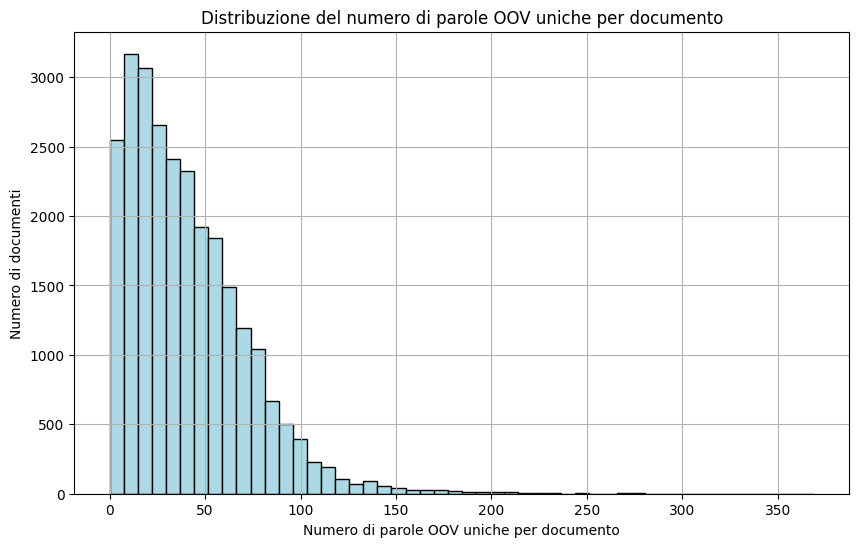

: 

In [ ]:
########################### WORD2VEC con embedding precalcolati spacy (senza vettore di zeri + counter oov) #################

from collections import Counter
import spacy
import numpy as np
import matplotlib.pyplot as plt

# Funzione per calcolare gli embedding e gestire parole valide/OOV uniche
def compute_embeddings_parallel(texts, nosologici, nlp, batch_size=1000, n_process=-1, max_oov_display=500):
    """
    Calcola gli embedding spaCy in parallelo e rileva le parole valide e OOV uniche.
    - texts: lista di testi.
    - nosologici: lista di identificativi associati ai testi.
    - batch_size: numero di documenti per batch.
    - n_process: (-1 per utilizzare tutti i core disponibili).
    - max_oov_display: numero massimo di parole OOV da stampare.
    """
    print("Calcolo degli embedding in corso...")

    # Inizializza gli insiemi e contatori
    oov_words_counter = Counter()  # Contatore per parole OOV
    valid_words_unique = set()  # Parole valide uniche
    oov_per_doc = []  # Numero di parole OOV per documento
    oov_details = []  # Dettagli OOV per documento (numero di OOV e testo originale, nosologico)

    # Utilizzo del pipe per elaborare i testi
    docs = nlp.pipe(texts, batch_size=batch_size, n_process=n_process)  # Elabora in batch
    embeddings = []

    for idx, doc in enumerate(docs):
        doc_embedding = []
        doc_oov = set()  # Parole OOV uniche per questo documento

        for token in doc:
            if not token.has_vector or np.all(token.vector == 0):  # Se il token non ha un embedding valido
                if token.text.strip():  # Escludi stringhe vuote o costituite solo da spazi
                    oov_words_counter[token.text] += 1  # Incrementa il conteggio per questa parola OOV
                    doc_oov.add(token.text)  # Aggiungi la parola OOV al set del documento
            else:
                valid_words_unique.add(token.text)  # Parola valida
                doc_embedding.append(token.vector)  # Aggiungi il vettore valido

        # Calcola l'embedding medio per il documento (ignorando le parole OOV)
        if doc_embedding:  # Se ci sono vettori validi
            embeddings.append(np.mean(doc_embedding, axis=0))
        else:  # Documento senza parole valide (tutte OOV)
            embeddings.append(None)  # Oppure puoi aggiungere un vettore di fallback (es. np.zeros(nlp.vocab.vectors_length))

        # Aggiungi il numero di OOV uniche per documento alla lista
        oov_per_doc.append(len(doc_oov))

        # Salva i dettagli OOV per questo documento
        oov_details.append((len(doc_oov), texts[idx], nosologici[idx]))

    # Calcola statistiche sulle OOV
    total_unique_words = len(valid_words_unique.union(oov_words_counter.keys()))
    oov_percentage_unique = (len(oov_words_counter.keys()) / total_unique_words) * 100

    print(f"Totale parole valide uniche: {len(valid_words_unique)}")
    print(f"Totale parole OOV uniche: {len(oov_words_counter.keys())}")
    print(f"Totale parole uniche nel dataset (OOV + valide): {total_unique_words}")
    print(f"Percentuale di parole OOV rispetto al totale di parole uniche: {oov_percentage_unique:.2f}%")

    # Stampa le prime 50 parole OOV uniche ordinate per frequenza
    print("\nPrime 50 parole OOV uniche ordinate per frequenza:")
    for i, (word, count) in enumerate(oov_words_counter.most_common(max_oov_display)):
        print(f"{i+1}. {word}: {count}")

    # Ordinamento dei documenti in base al numero di OOV (decrescente)
    sorted_oov_details = sorted(oov_details, key=lambda x: x[0], reverse=True)

    # Stampa delle righe della colonna ordinate in base alle OOV
    print("\nPrime 10 righe con il maggior numero di OOV:")
    for i, (num_oov, text, nosologico) in enumerate(sorted_oov_details[:10]):  # Mostra i primi 10 documenti
        print(f"{i+1}. Nosologico: {nosologico} | Numero di OOV: {num_oov} | Testo: {text}")

    print("Calcolo degli embedding completato.")

    # Grafico della distribuzione del numero di parole OOV per documento
    plt.figure(figsize=(10, 6))
    plt.hist(oov_per_doc, bins=50, color='lightblue', edgecolor='black')
    plt.title('Distribuzione del numero di parole OOV uniche per documento')
    plt.xlabel('Numero di parole OOV uniche per documento')
    plt.ylabel('Numero di documenti')
    plt.grid(True)
    plt.show()

    return np.array(embeddings)  # Restituisce una matrice di embedding di forma (n_righe, 300) dove 300 è la dimensione di ogni embedding

# Carica il dataset
X_texts = merged_dataset['testo_combinato_preprocessed']
y = merged_dataset['positivi']
nosologici = merged_dataset['nosologico'].tolist()  # Lista degli identificativi (colonna 'nosologico')

# Calcolo e salvataggio degli embedding
X_embeddings = compute_embeddings_parallel(X_texts, nosologici, nlp)
np.save('X_embeddings.npy', X_embeddings)  # Salva gli embedding su disco

# Per ricaricare gli embedding in futuro
# X_embeddings = np.load('X_embeddings.npy')


In [28]:
####################################### dimensione vocabolario modello spacy ###########################
vocab_size = len(nlp.vocab)
print(f"Dimensione del vocabolario del modello spaCy: {vocab_size}")


Dimensione del vocabolario del modello spaCy: 214301


In [ ]:
####################################################

In [ ]:
######################################################### RETI NEURALI

In [90]:
######################## CROSS VALIDATION ########################

from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import numpy as np
import pandas as pd

def eval_cross_validation(pipeline, X, y, skf):
    list_reports = []
    list_auc = []  # Lista per raccogliere i valori di AUC
    list_num_features = []  # Lista per raccogliere il numero di features per ogni fold

    # Metriche aggregate per ogni classe
    precision_sum = {}
    recall_sum = {}
    f1_sum = {}
    support_sum = {}  # Per il calcolo del supporto medio

    # Liste per calcolare deviazioni standard
    precision_values = {}
    recall_values = {}
    f1_values = {}

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Addestra il pipeline
        pipeline.fit(X_train, y_train)

        # Previsioni e probabilità
        y_pred = pipeline.predict(X_val)
        y_pred_prob = pipeline.predict_proba(X_val)[:, 1]  # Probabilità della classe positiva

        # Classification report per il fold
        report = classification_report(y_val, y_pred, output_dict=True)
        list_reports.append(report)

        # AUC per il fold
        auc = roc_auc_score(y_val, y_pred_prob)
        list_auc.append(auc)

        # Numero di features (fisso per embedding precalcolati)
        num_features = X.shape[1]
        list_num_features.append(num_features)

        # Somma le metriche per ogni classe
        for label, metrics in report.items():
            if label not in ["accuracy", "macro avg", "weighted avg"]:
                precision_sum[label] = precision_sum.get(label, 0) + metrics["precision"]
                recall_sum[label] = recall_sum.get(label, 0) + metrics["recall"]
                f1_sum[label] = f1_sum.get(label, 0) + metrics["f1-score"]
                support_sum[label] = support_sum.get(label, 0) + metrics["support"]

                # Aggiungi i valori per la deviazione standard
                precision_values[label] = precision_values.get(label, []) + [metrics["precision"]]
                recall_values[label] = recall_values.get(label, []) + [metrics["recall"]]
                f1_values[label] = f1_values.get(label, []) + [metrics["f1-score"]]

    # Calcola le medie delle metriche
    num_folds = skf.get_n_splits()
    precision_avg = {label: precision_sum[label] / num_folds for label in precision_sum}
    recall_avg = {label: recall_sum[label] / num_folds for label in recall_sum}
    f1_avg_per_class = {label: f1_sum[label] / num_folds for label in f1_sum}
    support_avg = {label: support_sum[label] / num_folds for label in support_sum}

    # Calcola le deviazioni standard
    precision_std = {label: np.std(precision_values[label]) for label in precision_values}
    recall_std = {label: np.std(recall_values[label]) for label in recall_values}
    f1_std = {label: np.std(f1_values[label]) for label in f1_values}

    # Media di AUC e numero di features
    auc_avg = np.mean(list_auc)
    num_features_avg = np.mean(list_num_features)

    # Crea un DataFrame riassuntivo
    df_avg = pd.DataFrame({
        "Precision": precision_avg,
        "Recall": recall_avg,
        "F1-Score": f1_avg_per_class,
        "Support Avg": support_avg,  # Supporto medio
        "Precision Std": precision_std,
        "Recall Std": recall_std,
        "F1-Score Std": f1_std,
    })

    return df_avg, auc_avg, f1_avg_per_class, num_features_avg


# Configura StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [78]:
########################################### convertire embedding spacy in un layer trainable #####################
#Per rendere trainabili gli embedding generati da SpaCy:
#1.Estrai gli embedding generati da SpaCy per ogni parola e crea una matrice di embedding.
#2.Aggiungi uno spazio per i token OOV, inizializzati casualmente.
#3.Utilizza un layer di embedding trainabile in PyTorch per gestire il backpropagation.

import torch
import torch.nn as nn
import numpy as np

# Dimensione degli embedding (dipende dal modello SpaCy, ad es. 300 per `it_core_news_md`)
embedding_dim = 300

# Costruzione della matrice di embedding
vocab = {word: idx for idx, word in enumerate(nlp.vocab.strings)}
embedding_matrix = np.zeros((len(vocab), embedding_dim))

# Riempi la matrice con i vettori SpaCy
for word, idx in vocab.items():
    vector = nlp.vocab[word].vector
    if vector.any():  # Solo se il vettore è disponibile
        embedding_matrix[idx] = vector
    else:
        embedding_matrix[idx] = np.random.uniform(0, 1, embedding_dim)  # Random per OOV

# Converti in tensore PyTorch
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

# Layer di embedding trainabile
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)  # Non congelato


#Trasformare il testo in sequenze di numeri: ogni parola viene sostituita con il suo indice nella matrice di embedding globale.
#Preparare i dati per la rete neurale: le reti neurali non elaborano direttamente il testo; richiedono input numerici con una lunghezza uniforme (grazie al padding o troncamento).
def tokenize_and_index_spacy(text, vocab, max_len):
    tokens = [vocab.get(word, len(vocab) - 1) for word in text.split()]  # Usa l'indice dell'OOV per le parole non trovate
    if len(tokens) < max_len:
        tokens += [0] * (max_len - len(tokens))  # Padding
    return tokens[:max_len]  # Trunca le sequenze troppo lunghe

# Applicare la tokenizzazione e il padding ai testi
max_len = 50  # Lunghezza massima delle sequenze
X_indices = [tokenize_and_index_spacy(text, vocab, max_len) for text in X_texts]
X_indices = torch.tensor(X_indices, dtype=torch.long)
#y = torch.tensor(y.tolist(), dtype=torch.float32)
# Se y è un tensore unidimensionale, cambiamo la sua forma a (26192, 1)
#y = y.view(-1, 1)


# Definiamo una rete neurale a valle del layer di embedding per il task di classificazione
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        _, (hidden, _) = self.lstm(embedded)  # hidden: [1, batch_size, hidden_dim]
        output = self.fc(hidden.squeeze(0))  # [batch_size, output_dim]
        return output

#class CNNClassifier(nn.Module):
    #def __init__(self, embedding_layer, num_filters, filter_sizes, output_dim):
        super(CNNClassifier, self).__init__()
        self.embedding = embedding_layer
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)

    #def forward(self, x):
        embedded = self.embedding(x).unsqueeze(1)  # [batch_size, 1, seq_len, embedding_dim]
        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = torch.cat(pooled, dim=1)
        output = self.fc(cat)
        return output


In [76]:
print(type(y))  # Dovrebbe essere un tensore PyTorch, tipo <class 'torch.Tensor'>
print(y.shape)  # Dovrebbe avere la forma (batch_size, 1) per la classificazione binaria


<class 'pandas.core.series.Series'>
(26192,)


In [94]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class LSTMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, embedding_layer, hidden_dim=128, output_dim=1, batch_size=64, epochs=5, lr=0.001):
        self.embedding_layer = embedding_layer
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.model = LSTMClassifier(self.embedding_layer, self.hidden_dim, self.output_dim)  

    def fit(self, X, y):
        # Creazione del modello LSTM
        if self.model is None:  # Se il modello non è stato ancora creato
            self.model = LSTMClassifier(self.embedding_layer, self.hidden_dim, self.output_dim)  # Crealo una sola volta
        
        # Ottimizzatore e loss function
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Convertiamo i dati di input in tensori
        X_tensor = torch.tensor(X, dtype=torch.long)
        y_tensor = torch.tensor(y.tolist(), dtype=torch.float32).view(-1, 1)
        
        # Creazione del DataLoader
        dataset = TensorDataset(X_tensor, y_tensor)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Addestramento
        self.model.train()
        for epoch in range(self.epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {running_loss/len(train_loader):.4f}")
        
        return self

    def predict(self, X):
        # Convertiamo i dati di input in tensori
        X_tensor = torch.tensor(X, dtype=torch.long)
        
        # Predizione
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor)
            preds = torch.round(torch.sigmoid(outputs)).squeeze().numpy()
        
        return preds


In [ ]:
#################################### NO SMOTE ###################################

import spacy
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline

# Creazione del modello LSTM nella pipeline
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)  # Non congelato

lstm_clf = LSTMWrapper(embedding_layer=embedding_layer, hidden_dim=128, output_dim=1, batch_size=64, epochs=5, lr=0.001)

# Usa gli embedding di SpaCy
X = X_indices
y = torch.tensor(y.tolist(), dtype=torch.float32)

#X = X.numpy()  # Tensore -> NumPy array
#y = y.numpy()  # Tensore -> NumPy array

# Esegui la cross-validation per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")

    # Crea la pipeline per il classificatore corrente
    #pipeline = Pipeline([('classificazione', clf)])
    pipeline = Pipeline([('classificazione', lstm_clf)])

    # Usa gli embedding precalcolati
    #X = X_embeddings
  
    # Fit della pipeline
    pipeline.fit(X, y)

    # Calcola le metriche usando la funzione 
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()



### Modello: LSTM ###


/tmp/ipykernel_493946/2681751499.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.long)


In [ ]:
##################### NO SMOTE #######################################

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Esegui la cross-validation per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")

    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline(('classificazione', clf))

    # Usa gli embedding precalcolati
    X = X_embeddings

    # Fit della pipeline
    pipeline.fit(X, y)

    # Calcola le metriche usando la funzione (modifica per adattare alla tua funzione eval_cross_validation)
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()


### Modello: extremeGradientBoosting ###
Classification report mediato:
   Precision    Recall  F1-Score  Support Avg  Precision Std  Recall Std  \
0   0.991002  0.979692  0.985312       2585.1       0.000824    0.002560   
1   0.174580  0.325462  0.226523         34.1       0.027427    0.063347   

   F1-Score Std  
0      0.001230  
1      0.037052  
AUC medio: 0.8799
Numero medio di features: 300.00


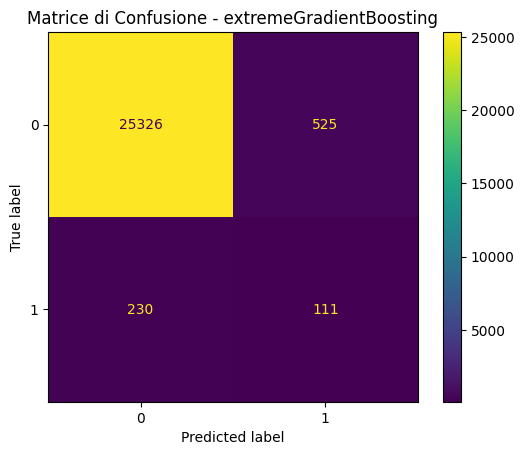

In [19]:
##################### SMOTE #######################################

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Esegui la cross-validation per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")

    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([('smote', SMOTE(random_state=42)),('classificazione', clf)])

    # Usa gli embedding precalcolati
    X = X_embeddings

    # Fit della pipeline
    pipeline.fit(X, y)

    # Calcola le metriche usando la funzione (modifica per adattare alla tua funzione eval_cross_validation)
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()



### Modello: extremeGradientBoosting ###
Classification report mediato:
   Precision    Recall  F1-Score  Support Avg  Precision Std  Recall Std  \
0   0.991203  0.976210  0.983647       2585.1       0.000867    0.002919   
1   0.159995  0.343109  0.217634         34.1       0.025568    0.065767   

   F1-Score Std  
0      0.001419  
1      0.035465  
AUC medio: 0.8906
Numero medio di features: 300.00


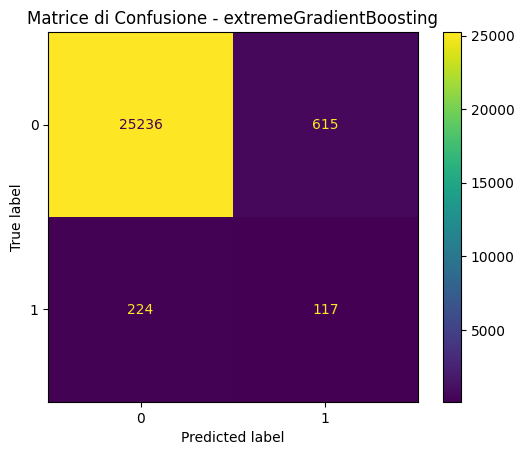

In [20]:
##################### SMOTE + UNDERSAMLING #######################################

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Esegui la cross-validation per ogni classificatore
for clf_name, clf in classifiers.items():
    print(f"\n### Modello: {clf_name} ###")

    # Crea la pipeline per il classificatore corrente
    pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=0.6)),  # Applica SMOTE fino al 60% della classe maggioritaria
    ('undersample', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),
    ('classificazione', clf)])

    # Usa gli embedding precalcolati
    X = X_embeddings

    # Fit della pipeline
    pipeline.fit(X, y)

    # Calcola le metriche usando la funzione (modifica per adattare alla tua funzione eval_cross_validation)
    df_avg, auc_avg, f1_avg_per_class, num_features_avg = eval_cross_validation(pipeline, X, y, skf)

    # Stampa i risultati
    print("Classification report mediato:")
    print(df_avg)
    print(f"AUC medio: {auc_avg:.4f}")
    print(f"Numero medio di features: {num_features_avg:.2f}")

    # Previsioni su tutto il dataset usando cross_val_predict
    y_pred = cross_val_predict(pipeline, X, y, cv=skf)

    # Visualizza la matrice di confusione
    ConfusionMatrixDisplay.from_predictions(y, y_pred)
    plt.title(f"Matrice di Confusione - {clf_name}")
    plt.show()


In [ ]:
##########################################################

In [ ]:
########################################### convertire embedding spacy in un layer trainable #####################
#Per rendere trainabili gli embedding generati da SpaCy:
#1.Estrai gli embedding generati da SpaCy per ogni parola e crea una matrice di embedding.
#2.Aggiungi uno spazio per i token OOV, inizializzati casualmente.
#3.Utilizza un layer di embedding trainabile in PyTorch per gestire il backpropagation.

import torch
import torch.nn as nn
import numpy as np

# Dimensione degli embedding (dipende dal modello SpaCy, ad es. 300 per `it_core_news_md`)
embedding_dim = 300

# Costruzione della matrice di embedding
vocab = {word: idx for idx, word in enumerate(nlp.vocab.strings)}
embedding_matrix = np.zeros((len(vocab), embedding_dim))

# Riempi la matrice con i vettori SpaCy
for word, idx in vocab.items():
    vector = nlp.vocab[word].vector
    if vector.any():  # Solo se il vettore è disponibile
        embedding_matrix[idx] = vector
    else:
        embedding_matrix[idx] = np.random.uniform(0, 1, embedding_dim)  # Random per OOV

# Converti in tensore PyTorch
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

# Layer di embedding trainabile
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)  # Non congelato


#Trasformare il testo in sequenze di numeri: ogni parola viene sostituita con il suo indice nella matrice di embedding globale.
#Preparare i dati per la rete neurale: le reti neurali non elaborano direttamente il testo; richiedono input numerici con una lunghezza uniforme (grazie al padding o troncamento).
def tokenize_and_index_spacy(text, vocab, max_len):
    tokens = [vocab.get(word, len(vocab) - 1) for word in text.split()]  # Usa l'indice dell'OOV per le parole non trovate
    if len(tokens) < max_len:
        tokens += [0] * (max_len - len(tokens))  # Padding
    return tokens[:max_len]  # Trunca le sequenze troppo lunghe

# Applicare la tokenizzazione e il padding ai testi
max_len = 50  # Lunghezza massima delle sequenze
X_indices = [tokenize_and_index_spacy(text, vocab, max_len) for text in X_texts]
X_indices = torch.tensor(X_indices, dtype=torch.long)
y = torch.tensor(y.tolist(), dtype=torch.float32)


# Definiamo una rete neurale a valle del layer di embedding per il task di classificazione
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        _, (hidden, _) = self.lstm(embedded)  # hidden: [1, batch_size, hidden_dim]
        output = self.fc(hidden.squeeze(0))  # [batch_size, output_dim]
        return output

#class CNNClassifier(nn.Module):
    #def __init__(self, embedding_layer, num_filters, filter_sizes, output_dim):
        super(CNNClassifier, self).__init__()
        self.embedding = embedding_layer
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)

    #def forward(self, x):
        embedded = self.embedding(x).unsqueeze(1)  # [batch_size, 1, seq_len, embedding_dim]
        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = torch.cat(pooled, dim=1)
        output = self.fc(cat)
        return output


In [26]:
# Istanzia il modello
hidden_dim = 128
output_dim = 1  # Classificazione binaria
model = LSTMClassifier(embedding_layer, hidden_dim, output_dim)

# Ottimizzatore e funzione di perdita
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_indices).squeeze(1)
    loss = criterion(predictions, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/50, Loss: 0.6399558186531067
Epoch 2/50, Loss: 0.4820992052555084
Epoch 3/50, Loss: 0.3614025115966797
Epoch 4/50, Loss: 0.270813912153244
Epoch 5/50, Loss: 0.20477615296840668
Epoch 6/50, Loss: 0.15821735560894012
Epoch 7/50, Loss: 0.1264580935239792
Epoch 8/50, Loss: 0.10544833540916443
Epoch 9/50, Loss: 0.091912180185318
Epoch 10/50, Loss: 0.08337698131799698
Epoch 11/50, Loss: 0.07810374349355698
Epoch 12/50, Loss: 0.07492153346538544
Epoch 13/50, Loss: 0.07306697964668274
Epoch 14/50, Loss: 0.07204946875572205
Epoch 15/50, Loss: 0.07155667245388031
Epoch 16/50, Loss: 0.07138637453317642
Epoch 17/50, Loss: 0.07140602171421051
Epoch 18/50, Loss: 0.07152844965457916
Epoch 19/50, Loss: 0.0716959536075592
Epoch 20/50, Loss: 0.07187043875455856
Epoch 21/50, Loss: 0.07202740013599396
Epoch 22/50, Loss: 0.07215297967195511
Epoch 23/50, Loss: 0.07224012911319733
Epoch 24/50, Loss: 0.07228561490774155
Epoch 25/50, Loss: 0.07228895276784897
Epoch 26/50, Loss: 0.0722523108124733
Epoch

In [30]:
########################################################